In [1]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt 
import module.content as content
import module.features as features
from joblib import load
import argparse
import time

In [2]:
# this block assign the parameter: (like args_extractor)
size = 3
timestamp = '0025'
index_slice = 650

In [3]:
# Here we set the paramater
mask_centre = (700, 810)
radius = 550
keyword = 'SHP'

# get the path for target slice
current_path = os.getcwd()
all_timestamp = content.get_folder(current_path, keyword)
timestamp_index = [all_timestamp.index(i) for i in all_timestamp if timestamp in i]
sub_path = os.path.join(current_path, all_timestamp[timestamp_index[0]])
sub_all_tif = content.get_allslice(sub_path)
target_slice = sub_all_tif[index_slice-1]

# get features
mask, feature_index = features.get_mask(sub_all_tif[0], mask_centre, radius, size)
if size == 1:
	feature_4D, feature_3D = features.get_all_features_1(target_slice, feature_index, keyword)
elif size == 3:
	feature_4D, feature_3D = features.get_all_features_3(target_slice, feature_index, keyword)
elif size == 5:
	feature_4D, feature_3D = features.get_all_features_5(target_slice, feature_index, keyword)
else:
	raise ValueError('Please input the right size, should be 1, 3 or 5.')

# write the image

coordinate = mask.nonzero()
height, width = mask.shape

Pick one slice to get mask and features index
Current slice: /Users/gavin/MSc-Project/SHP15_T113_0025/SHP15_T113__0025_0650.rec.16bit.tif
Loading 9 images...
Finished!
Getting features...
Finished!
Concatenating features...
Finished!


In [4]:
model_4D = 'gmmfull_4D_3_3x3_0025'
model_3D = 'gmmfull_3D_3_3x3_0025'

# load the model from 'model' folder
model_4D_path = os.path.join(current_path, 'model', model_4D+'.model')
model_3D_path = os.path.join(current_path, 'model', model_3D+'.model')
model_4D_type = load(model_4D_path)
model_3D_type = load(model_3D_path)


# segment
prediction_4D = model_4D_type.predict(feature_4D)
prediction_3D = model_3D_type.predict(feature_3D)

In [535]:
model_4D_type.means_

array([[28117.66811964, 28118.23980811, 28125.29758651, 28117.18859358,
        28116.10750547, 28123.70689324, 28112.14384102, 28112.09487806,
        28118.44065849, 28113.75612051, 28114.19076296, 28121.56056704,
        28112.42537849, 28111.76482313, 28119.7609838 , 28106.58361719,
        28107.40406734, 28113.94163375, 28112.71916348, 28113.64973122,
        28119.77820429, 28111.7275602 , 28112.67622311, 28118.80361275,
        28104.57527534, 28106.78789594, 28111.85423811, 21991.29862649,
        21994.83785099, 21996.24347955, 21992.7591226 , 21994.61779851,
        21997.34724892, 21991.88700517, 21994.1779859 , 21997.33972456,
        21989.88527788, 21991.18429851, 21992.19606583, 21990.20403742,
        21989.43905629, 21992.03472504, 21989.59974734, 21989.41128292,
        21992.48713181, 21991.36053608, 21992.7025327 , 21993.55532055,
        21991.65004587, 21990.93892118, 21993.19940788, 21990.76178719,
        21990.15067429, 21993.20916713, 28081.63884613, 28089.82

In [539]:
model_4D_type.covariances_

array([[ 2071282.98607581,  2002719.08403437,  2114349.02450757,
         1976323.54227333,  1923474.26892428,  2029804.07329862,
         2044819.85034149,  1986485.57136218,  2110263.89044385,
         2134102.05506687,  2026894.19141297,  2146734.06393211,
         2021482.38903754,  1934934.25465863,  2052775.94717066,
         2107699.82359259,  2017290.74723499,  2149488.55447321,
         2364805.74290256,  2227123.1759377 ,  2352739.02395789,
         2238807.34328704,  2121363.39523141,  2252825.30499391,
         2338519.65493326,  2224845.34844701,  2364136.25825898,
          836868.72045808,   765988.675516  ,   780011.81614374,
          793496.27496509,   732857.53679805,   750533.45910119,
          825970.40642445,   763782.55016749,   780995.79297875,
          813241.20171802,   746160.69721662,   765604.17955087,
          768854.36787598,   713184.28391664,   736100.17706357,
          802261.86767809,   745131.37297295,   771430.37535124,
          846369.57367431

In [385]:
target_slice

'/Users/gavin/MSc-Project/SHP15_T113_0025/SHP15_T113__0025_0650.rec.16bit.tif'

In [355]:
model_4D_type.cluster_centers_.shape

(375, 81)

In [439]:
model_3D_type.cluster_centers_.shape

(67, 27)

# 4D segmentation

In [373]:
pore_4D = [i for i in range(1,375)]

In [391]:
prediction_4D[463762]

27

In [465]:
np.argwhere(coordinate[0]==383)

array([[57897],
       [57898],
       [57899],
       [57900],
       [57901],
       [57902],
       [57903],
       [57904],
       [57905],
       [57906],
       [57907],
       [57908],
       [57909],
       [57910],
       [57911],
       [57912],
       [57913],
       [57914],
       [57915],
       [57916],
       [57917],
       [57918],
       [57919],
       [57920],
       [57921],
       [57922],
       [57923],
       [57924],
       [57925],
       [57926],
       [57927],
       [57928],
       [57929],
       [57930],
       [57931],
       [57932],
       [57933],
       [57934],
       [57935],
       [57936],
       [57937],
       [57938],
       [57939],
       [57940],
       [57941],
       [57942],
       [57943],
       [57944],
       [57945],
       [57946],
       [57947],
       [57948],
       [57949],
       [57950],
       [57951],
       [57952],
       [57953],
       [57954],
       [57955],
       [57956],
       [57957],
       [57958],
       [

In [466]:
np.argwhere(coordinate[1]==855)

array([[  4991],
       [  5309],
       [  5633],
       ...,
       [944933],
       [945257],
       [945575]])

In [469]:
for i in np.argwhere(coordinate[0]==383):
    for j in np.argwhere(coordinate[1]==855):
        if i == j:
            print(i)

[58398]


In [515]:
a = str(pore_4D)[1:-1]

In [516]:
a.replace(' ', '')

'1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,28

In [517]:
b =str(pore_3D)[1:-1]

In [518]:
b.replace(' ','')

'1,2,3,4,5,6,7,8,9,10,11,12,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66'

In [435]:
pore_4D_1 = [i for i in range(1, 26)]
pore_4D_2 = [i for i in range(35, 375)]
pore_4D = pore_4D_1 + pore_4D_2

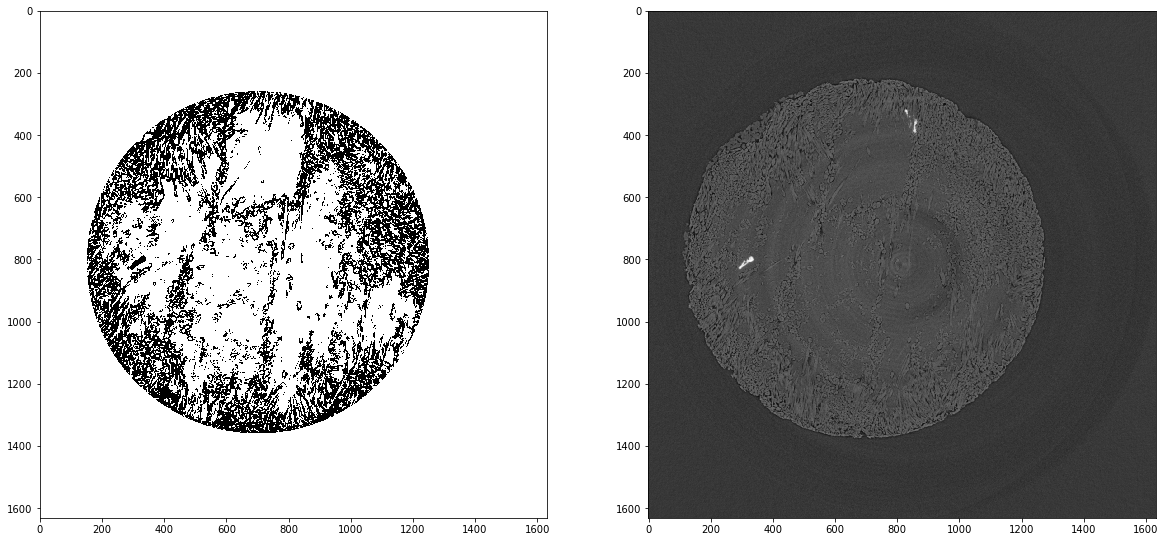

In [9]:
pore_4D = [2]
final_img_4D = np.ones((height,width), np.uint8)
for element in pore_4D:
    zero_point_4D_co = np.argwhere(prediction_4D==element)
    for i in zero_point_4D_co:
        final_img_4D[coordinate[0][i], coordinate[1][i]] = 0
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(final_img_4D, 'gray')
plt.subplot(122)
raw_img = cv2.imread(target_slice, -1)
plt.imshow(raw_img, 'gray')
# plt.savefig('4D_segment_diag.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

# 3D segmentation

In [482]:
print(model_3D_type.cluster_centers_[12])

[13275.  11376.  12496.5 14111.  14044.5 15318.  16228.  18125.5 20770.5
 14924.5 11746.  12369.  15342.  13617.  15268.5 16327.  17313.5 20233.
 15304.5 11902.5 12242.  14652.  12918.  14729.  14709.5 14869.  18673.5]


In [470]:
prediction_3D[58398]

15

In [523]:
pore_3D_1 = [i for i in range(1, 13)]
pore_3D_2 = [i for i in range(16, 67)]
pore_3D = pore_3D_1 + pore_3D_2

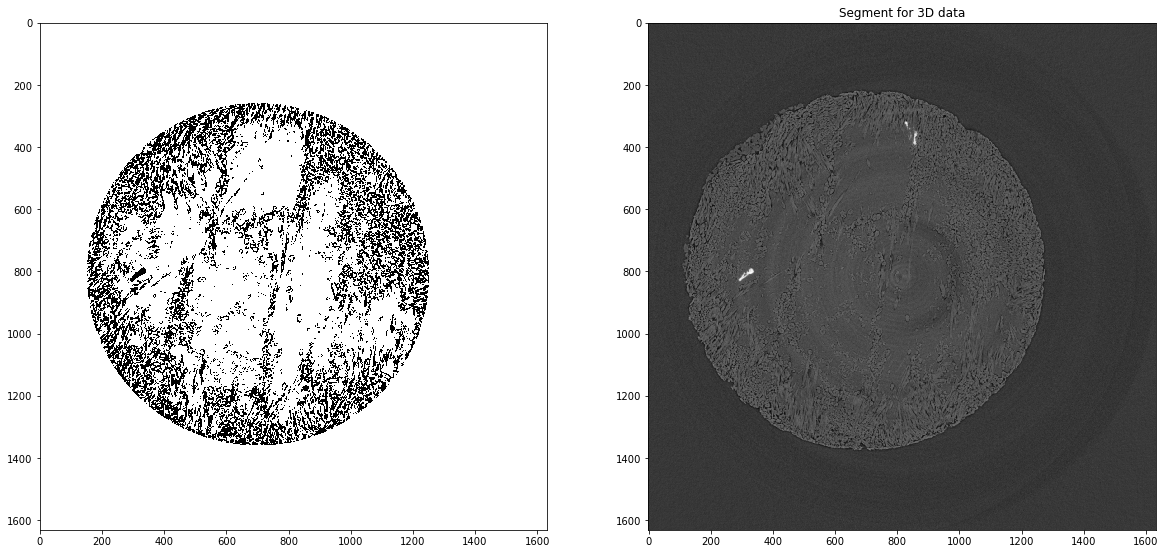

In [11]:
pore_3D = [1]
final_img_3D = np.ones((height,width), np.uint8)
for element in pore_3D:
    zero_point_3D_co = np.argwhere(prediction_3D==element)
    for j in zero_point_3D_co:
        final_img_3D[coordinate[0][j], coordinate[1][j]] = 0
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(final_img_3D, 'gray')
plt.subplot(122)
plt.imshow(raw_img, 'gray')
plt.title('Segment for 3D data')
# plt.savefig('3D_segment_mini.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

test conv

In [74]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt 
import module.content as content
import module.features as features
from joblib import load
import argparse
import time

import tensorflow as tf 

In [110]:
model_4D = 'mini_kmeans_4D_3_3x3'
model_3D = 'mini_kmeans_3D_3_3x3'
timestamp = '0025'
index_slice = 601
pore_4D = '1,2'
pore_3D = '2'

In [111]:
# Here we set the paramater
mask_centre = (700, 810)
radius = 550
keyword = 'SHP'
# transfer the pore from string to list
pore_4D = pore_4D.split(',')
pore_4D = [int(i) for i in pore_4D]
pore_3D = pore_3D.split(',')
pore_3D = [int(i) for i in pore_3D]

In [71]:
# get the path for target slice
current_path = os.getcwd()
all_timestamp = content.get_folder(current_path, keyword)
timestamp_index = [all_timestamp.index(i) for i in all_timestamp if timestamp in i]
sub_path = os.path.join(current_path, all_timestamp[timestamp_index[0]])
sub_all_tif = content.get_allslice(sub_path)

In [72]:
sub_path_previous = os.path.join(current_path, all_timestamp[timestamp_index[0]-1])
sub_path_next = os.path.join(current_path, all_timestamp[timestamp_index[0]+1])
begin_slice = index_slice - 1
end_slice = index_slice + 1

In [73]:
# load the model from 'model' folder
model_4D_path = os.path.join(current_path, 'model', model_4D+'.model')
model_3D_path = os.path.join(current_path, 'model', model_3D+'.model')
model_4D_type = load(model_4D_path)
model_3D_type = load(model_3D_path)

centre_4D = model_4D_type.cluster_centers_
centre_3D = model_3D_type.cluster_centers_

num_centre_3D = centre_3D.shape[0]
num_centre_4D = centre_4D.shape[0]


In [75]:
image_batch, height, width = features.get_3D_structure(sub_path, begin_slice, end_slice)
image_batch_previous, _, _ = features.get_3D_structure(sub_path_previous, begin_slice, end_slice)
image_batch_next, _, _ = features.get_3D_structure(sub_path_next, begin_slice, end_slice)

Current timestamp: /Users/gavin/MSc-Project/SHP15_T113_0025
Creating image batch...
Finished!
Current timestamp: /Users/gavin/MSc-Project/SHP15_T113_0024
Creating image batch...
Finished!
Current timestamp: /Users/gavin/MSc-Project/SHP15_T113_0026
Creating image batch...
Finished!


In [76]:
conv_stride = [1,1,1,1,1]
# for 3D kernel
kernel_3D_list = [tf.reshape(tf.constant(i, tf.float32), (3,3,3,1,1)) for i in centre_3D]
constant_3D_list = [np.sum(i**2) for i in centre_3D]

# treat 4D convolution as the combination of 3D convolution
kernel_4D_list_1 = [tf.reshape(tf.constant(i[:27], tf.float32), (3,3,3,1,1)) for i in centre_4D]
kernel_4D_list_2 = [tf.reshape(tf.constant(i[27:54], tf.float32), (3,3,3,1,1)) for i in centre_4D]
kernel_4D_list_3 = [tf.reshape(tf.constant(i[54:81], tf.float32), (3,3,3,1,1)) for i in centre_4D]
constant_4D_list = [np.sum(i**2) for i in centre_4D]

In [77]:
x_3D = tf.compat.v1.placeholder(tf.float32, shape=(1, end_slice-begin_slice+1, height, width, 1))

# layer for 3D data
layer_list_3D = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_3D_list]
# layer for 4D data
layer_list_4D_1 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_1]
layer_list_4D_2 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_2]
layer_list_4D_3 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_3]
print('Finished!')

Finished!


In [78]:
# run the graph
with tf.compat.v1.Session() as sess:
	print('3D segmentation...')
	result = [sess.run(i, feed_dict={x_3D:image_batch}) for i in layer_list_3D]
	print('4D segmentation...')
	result_4D_1 = [sess.run(i, feed_dict={x_3D:image_batch_previous}) for i in layer_list_4D_1]
	result_4D_2 = [sess.run(i, feed_dict={x_3D:image_batch}) for i in layer_list_4D_2]
	result_4D_3 = [sess.run(i, feed_dict={x_3D:image_batch_next}) for i in layer_list_4D_3]


3D segmentation...
4D segmentation...


In [79]:
print('Calculating distance...')
# reshape and calculate the distance
result_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result]

result_4D_1_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_1]
result_4D_2_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_2]
result_4D_3_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_3]

distance_list = [constant_3D_list[i]-2*result_reshape[i] for i in range(num_centre_3D)]
distance_list_4D = [constant_4D_list[i]-2*result_4D_1_reshape[i]-2*result_4D_2_reshape[i]-2*result_4D_3_reshape[i] for i in range(num_centre_4D)]
print('Finished!')

Calculating distance...
Finished!


In [80]:
mask = np.zeros((height, width), np.uint8)
cv2.circle(mask, mask_centre, radius, 1, thickness=-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [113]:
pore_4D

[1, 2]

In [115]:
compare_3D = [distance_list[pore_3D[0]] < distance_list[j] for j in range(num_centre_3D) if j != pore_3D[0]]
for element in pore_3D[1:]:
	compare_3D_ = [distance_list[element] < distance_list[j] for j in range(num_centre_3D) if j != element]
	for i in range(len(compare_3D)):
		compare_3D[i] += compare_3D_ 

In [116]:
compare_4D = [distance_list_4D[pore_4D[0]] < distance_list_4D[j] for j in range(num_centre_4D) if j != pore_4D[0]]
for element in pore_4D[1:]:
	compare_4D_ = [distance_list_4D[element] < distance_list_4D[j] for j in range(num_centre_4D) if j != element]
	for i in range(len(compare_4D)):
		compare_4D[i] += compare_4D_[i]

In [117]:
segment_3D = mask
for i in compare_3D:
	segment_3D = segment_3D * i

segment_4D = mask
for i in compare_4D:
	segment_4D = segment_4D * i

# inverse color for plotting
segment_inv_3D = cv2.bitwise_not(segment_3D)
segment_inv_4D = cv2.bitwise_not(segment_4D)

Text(0.5, 1.0, 'Original slice \n SHP15_T113__0025_0601.rec.16bit.tif')

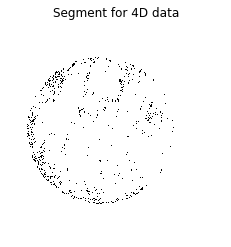

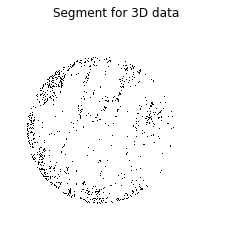

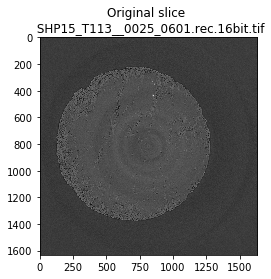

In [118]:
# plot the picture
plt.figure()
plt.imshow(segment_inv_4D[1], 'gray')
plt.axis('off')
plt.title('Segment for 4D data')

plt.figure()
plt.imshow(segment_inv_3D[1], 'gray')
plt.axis('off')
plt.title('Segment for 3D data')

plt.figure()
img = cv2.imread(sub_all_tif[index_slice-1], -1)
plt.imshow(img, 'gray')
plt.title('Original slice \n {string}'.format(string=os.path.basename(sub_all_tif[index_slice-1])))
